# Bayesian Decision based on Gaussian 

16307110216 Ruian He

### Extract data from downloaded files

As the data is stored in bytes, we need to follow the strcture of the files to extract.

In [1]:
import numpy as np
import gzip,struct,os


'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
'''

def extract_image(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num,row,col = struct.unpack('>4I',buf.read(4*4))
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, file_path))
        image = np.frombuffer(buf.read(num*row*col), dtype=np.uint8)
        return image.reshape(num,row,col).astype(int)
    
'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
'''
    
def extract_label(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num = struct.unpack('>2I',buf.read(2*4))
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, file_path))
        label = np.frombuffer(buf.read(num), dtype=np.uint8)
        return label.astype(int)

Then we do the above approaches on our MNIST dataset.

In [2]:
data_dir = '../minist'

train_image_file = "train-images-idx3-ubyte.gz"
train_label_file = "train-labels-idx1-ubyte.gz"
test_image_file = "t10k-images-idx3-ubyte.gz"
test_label_file = "t10k-labels-idx1-ubyte.gz"

X_train = extract_image(os.path.join(data_dir,train_image_file))
print('Training data shape: ', X_train.shape)
y_train = extract_label(os.path.join(data_dir,train_label_file))
print('Training labels shape: ', y_train.shape)
X_test = extract_image(os.path.join(data_dir,test_image_file))
print('Test data shape: ', X_test.shape)
y_test = extract_label(os.path.join(data_dir,test_label_file))
print('Test labels shape: ', y_test.shape)

Extracting: ../minist/train-images-idx3-ubyte.gz
Training data shape:  (60000, 28, 28)
Extracting: ../minist/train-labels-idx1-ubyte.gz
Training labels shape:  (60000,)
Extracting: ../minist/t10k-images-idx3-ubyte.gz
Test data shape:  (10000, 28, 28)
Extracting: ../minist/t10k-labels-idx1-ubyte.gz
Test labels shape:  (10000,)


### Visualize and Preprocess the data

First of all, we are interested in how the dataset looks like and whether it is valid.

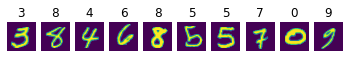

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

choice = np.random.choice(X_test.shape[0],10)
random_image = X_test[choice]
random_label = y_test[choice]

fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(random_label[i])
    ax[i].imshow(random_image[i])
    ax[i].axis('off')

We also can plot the average image for every digit, and get a general view over all training data.

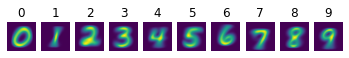

In [4]:
fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(i)
    ax[i].imshow(np.average(X_train[np.where(y_train == i)],axis=0))
    ax[i].axis('off')

### Bayesian Decision Model

Next, we start to build Bayesian Decision model from scratch. As the data follow Gaussion distribution, we can calculate the miu and sigma of the Gaussion distribution for every digit and we know the prior for each digit from the training set.

When we predict, according to the bayesian theorem, we can get posterior = likelihood * prior / evidence and use log
on both sides. As we only need to compare the relative size, we can ignore that evidence which is the
same for all posteriors. Then the final one to compare is log(prior) + log(likelihood).The digit class which get the largest posterior will be the choice.

In [5]:
class BayesianDecision(object):
    def __init__(self):
        self.eps = 1e-5
        self.smooth = 1000
        
    # get the miu and sigma for every digit
    def train(self, X, y):
        n_features = X.shape[1]
        self.prior = np.bincount(y)/y.shape[0]
        self.miu = np.zeros((10,n_features))
        self.var = np.zeros((10,n_features))
        self.cov = np.zeros((10,n_features,n_features))
        for i in range(10):
            select = X[np.where(y == i)]
            self.miu[i] = np.mean(select,axis=0)
            self.var[i] = np.var(select,axis=0) + self.smooth
            self.cov[i] = np.cov(select.T) + self.smooth
        
    # Predict test set using the bayes theorem
    def predict(self, X, mode):
        likelihood = np.zeros((10,X.shape[0]))
        for i in range(10):
            diff = X - self.miu[i]
            if mode == 'multi':
                det_sqrt = np.sqrt(np.linalg.det(self.cov[i]))
                likelihood[i] = np.log(np.exp(np.diag(-1/2*diff.dot(np.linalg.pinv(self.cov[i])).dot(diff.T)))/(det_sqrt+1e-5))
            else:
                possibility = np.exp(-1/2*np.square(diff)/self.var[i])/np.sqrt(self.var[i])
                likelihood[i] = np.sum(np.log(possibility),axis=1)
        posterior = likelihood + np.log(self.prior+self.eps)[:,np.newaxis]
        return np.argmax(posterior,axis = 0)

### Train the model

Now we get the model and the data,then we can start training and testing.

In [8]:
# first reshape train data to fit matrix calculus
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test  = np.reshape(X_test,  (X_test.shape[0],  -1))
print(X_train.shape, X_test.shape)

model = BayesianDecision()
model.train(X_train,y_train)

y_pred = model.predict(X_test, 'mono')
accuracy = np.sum(y_test == y_pred)/y_test.shape[0]
print("The monovariable model accuracy is:",accuracy)

y_pred = model.predict(X_test, 'multi')
accuracy = np.sum(y_test == y_pred)/y_test.shape[0]
print("The multivariable model accuracy is:",accuracy)

(60000, 784) (10000, 784)
The monovariable model accuracy is: 0.815


/home/ruianhe/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


The multivariable model accuracy is: 0.8459


Moreover, we can look into accuracies in every digit class and plot the confusion matrix.

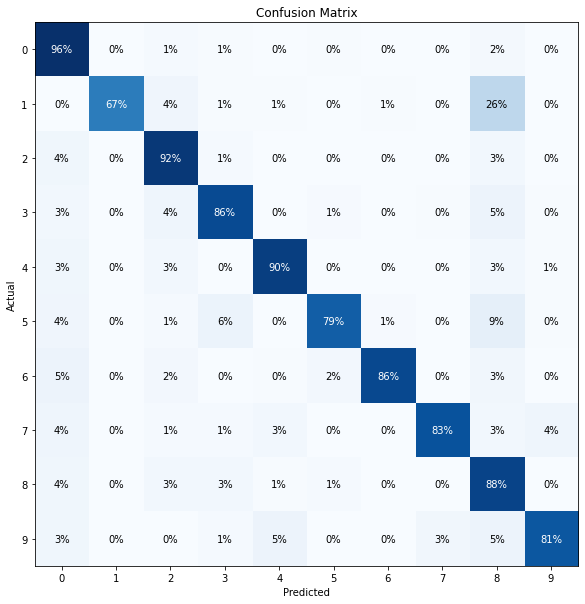

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cm,cmap=plt.cm.Blues)

ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(10), yticklabels=range(10),
           title='Confusion Matrix',
           ylabel='Actual',
           xlabel='Predicted')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, 
                s = format(int(cm[i, j]*100 + 0.5) , 'd') + '%', 
                ha = "center", 
                va = "center", 
                color = "white"  if cm[i, j] > 0.5 else "black")